In [9]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import sys
import os
from config import Config
from models import transformer
from losses import *
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re

In [2]:
new_data = pd.read_csv('../data/processed/processed_6.csv')

In [3]:
train_data=new_data[new_data.folds.isin([0,1,2])].reset_index(drop=True)
# train_data=shuffle(train_data).reset_index().drop(columns='index')
val_data = new_data[new_data.folds==3].reset_index().drop(columns='index')
test_data = new_data[new_data.folds==4].reset_index().drop(columns='index')

In [4]:
train_data

,text,folds,acholi,english,luganda,lumasaba,runyankore,swahili
0,government constructed better health centers r...,0,0,1,0,0,0,0
1,company celebrated twenty years existence last...,0,0,1,0,0,0,0
2,many people have lost their lives sexually tra...,0,0,1,0,0,0,0
3,civil servants receive their pension fund upon...,0,0,1,0,0,0,0
4,teachers also among civil servants,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
130704,okuyiikuula obugagga ttaka kusobola okubeera a...,2,0,0,1,0,0,0
130705,biki ebyetaagisa okusobola okukola omulimu oku...,2,0,0,1,0,0,0
130706,gavumenti ekoze enteekateeka ennungi abantu ok...,2,0,0,1,0,0,0
130707,abantu balina okulya okunywa,2,0,0,1,0,0,0


In [20]:
re.sub('<.*?>','','<html> this is a boy />')

' this is a boy />'

In [29]:
train_data[v]

,text,folds,acholi,english,luganda,lumasaba,runyankore,swahili


In [5]:
# train_corpus = ' '.join(train_data.text.values.tolist())
unique_word_count = Counter()
for i in train_data.text.values:
    for word in i.split():
        unique_word_count[word]+=1

In [6]:
word_counts=list(unique_word_count.values())
words=list(unique_word_count.keys())
indexes = sorted(range(len(word_counts)), key=lambda k: word_counts[k])
sorted_words=np.array(words)[indexes]
sorted_word_counts=np.array(word_counts)[indexes]

In [7]:
word_number=list(Counter(sorted_word_counts).keys())
word_number = [str(x) for x in word_number]
word_number_count=list(Counter(sorted_word_counts).values())

Text(0, 0.5, 'Counts')

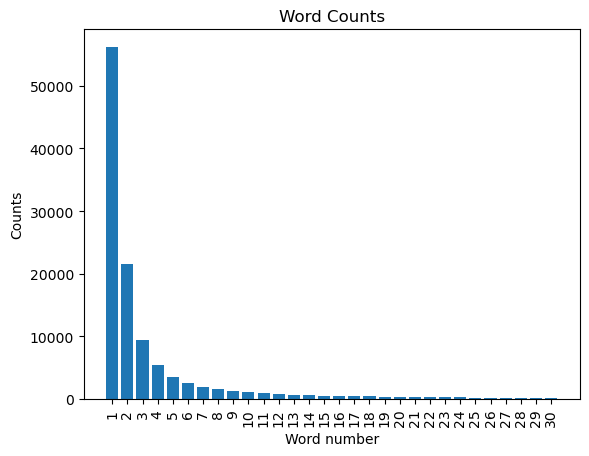

In [8]:
plt.bar(word_number[:30],word_number_count[:30])
plt.xticks(rotation=90)
plt.title("Word Counts")
plt.xlabel("Word number")
plt.ylabel("Counts")

In [9]:
tokenizer = Tokenizer(num_words=len(unique_word_count))
tokenizer.fit_on_texts(train_data.text)

In [10]:
max_length=8
train_sequences=tokenizer.texts_to_sequences(train_data.text)
train_padded_sequences = pad_sequences(train_sequences,maxlen=max_length,padding='post',truncating='post')

val_sequences=tokenizer.texts_to_sequences(val_data.text)
val_padded_sequences = pad_sequences(val_sequences,maxlen=max_length,padding='post',truncating='post')

test_sequences=tokenizer.texts_to_sequences(test_data.text)
test_padded_sequences = pad_sequences(test_sequences,maxlen=max_length,padding='post',truncating='post')

In [11]:
train_data.iloc[:,2:].sum()

acholi        33193
english       15157
luganda       16993
lumasaba      18639
runyankore    22218
swahili       24509
dtype: int64

In [27]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath='/home/g007markphillip/language_classification2/weights/cp-{epoch:04d}.ckpt',
                    save_weights_only=True,
                    save_freq='epoch')

w_array = np.ones([6,6])
w_array[2,4]=10
w_array[2,3]=10
w_array[4,2]=15
w_array[4,3]=15
w_array[3,4]=10

model = transformer(max_length=8,count=len(unique_word_count))
optimizer = tf.keras.optimizers.Adam(1e-5)

loss = WeightedCategoricalCrossentropy(w_array)

model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])
model.summary()
model.fit(train_padded_sequences, train_data[['english','acholi','luganda','lumasaba','runyankore','swahili']].values,
      validation_data=(val_padded_sequences ,val_data[['english','acholi','luganda','lumasaba','runyankore','swahili']].values),
      epochs=100,
      batch_size=512,
      callbacks=[cp_callback]
         )

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
token_and_position_embedding (None, 8, 32)             3774336   
_________________________________________________________________
transformer_block_1 (Transfo (None, 8, 32)             30560     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 32)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 198       
Total params: 3,805,094
Trainable params: 3,805,094
Non-trainable params: 0
_________________________________________________

In [13]:
# tf.train.latest_checkpoint('/home/g007markphillip/language_classification/weights/')
# model.load_weights('/home/g007markphillip/language_classification/weights/cp-0004.ckpt')
.

SyntaxError: invalid syntax (3328484076.py, line 3)

In [28]:
import numpy as np
pred_values=model.predict(test_padded_sequences)
pred_values = np.argmax(pred_values,1).astype('int')
true_values=test_data[['english','acholi','luganda','lumasaba','runyankore','swahili']].values
true_values=np.argmax(true_values,1).astype('int')

In [29]:
pred_values

array([5, 5, 5, ..., 1, 1, 1])

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(true_values,pred_values)

cm_df=pd.DataFrame(cm,index=['english','acholi','luganda','lumasaba','runyankore','swahili'],\
                   columns=['english','acholi','luganda','lumasaba','runyankore','swahili'])

Text(0.5, 23.52222222222222, 'Y_PRED')

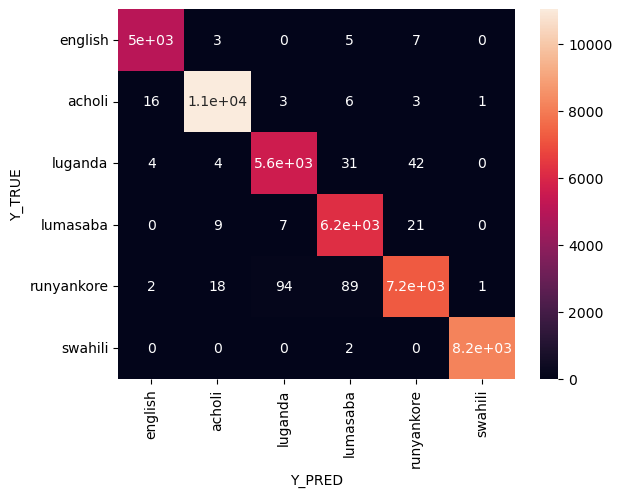

In [31]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [18]:
dsf

NameError: name 'dsf' is not defined

Text(0.5, 23.52222222222222, 'Y_PRED')

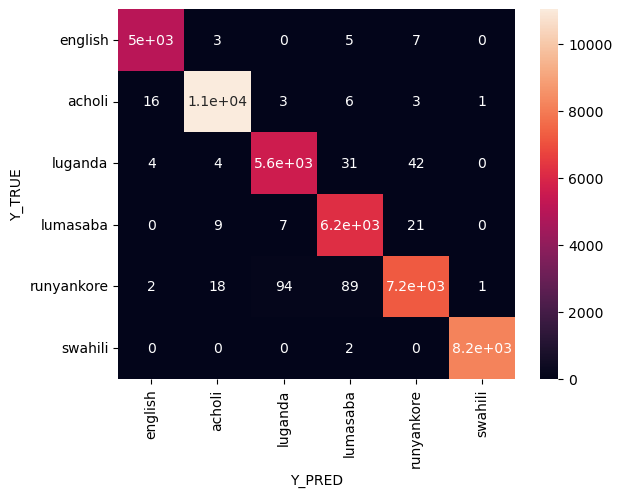

In [32]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [33]:
from sklearn.metrics import classification_report
print(classification_report(true_values,pred_values))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5052
           1       1.00      1.00      1.00     11064
           2       0.98      0.99      0.98      5664
           3       0.98      0.99      0.99      6214
           4       0.99      0.97      0.98      7406
           5       1.00      1.00      1.00      8169

    accuracy                           0.99     43569
   macro avg       0.99      0.99      0.99     43569
weighted avg       0.99      0.99      0.99     43569



In [34]:
embeddings=model.layers[1](test_padded_sequences).numpy().sum(1)

In [35]:
embeddings.shape

(43569, 32)

In [36]:
inverse_classes={0:'english',1:'acholi',2:'luganda',3:'lumaasaba',4:'runyankore',5:'swahili'}
vocab=pd.DataFrame(pred_values)[0].map(inverse_classes).tolist()

In [37]:
!ls

'explore autoencoder.ipynb'   metadata_test_multi.tsv
 flagged		      train.ipynb
 make_dataset_and_eda.ipynb   vectors_test_multi.tsv


In [39]:
import io
out_v = io.open('vectors_test_multi.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata_test_multi.tsv', 'w', encoding='utf-8')

for index, word in enumerate(vocab):
    vec = embeddings[index]
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
text=np.array(['lakini ambacho zaidi ujumbe wachezaji wawili'])
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text,maxlen=max_length,padding='post',truncating='post')
prediction = model.predict(text)

prediction = np.argmax(prediction,1).astype('int').tolist()
inverse_classes[prediction[0]]

In [ ]:
import gradio as gr
# dict_={value:key for key,value in classes.items()}


def function_(input_):
#     text=to_lower(remove_punctuation(input_))
    text=np.array([input_])
    text = tokenizer.texts_to_sequences(text)
    text = pad_sequences(text,maxlen=max_length,padding='post',truncating='post')
    prediction = model.predict(text)
   
    prediction = np.argmax(prediction,1).astype('int').tolist()
    return inverse_classes[prediction[0]]


ui = gr.Interface(
    function_,
    title="Language Classification",
    description='Enter Text',
    inputs=gr.inputs.Textbox(lines=5),
    outputs=gr.outputs.Textbox(label='Language')
)
ui.launch(share=True)

In [ ]:
test_data[test_data.luganda==1]

In [ ]:
test_data=test_data[['text','english','acholi','luganda','lumasaba','runyankore','swahili']]

In [ ]:
false_pred_index=np.where((true_values!=pred_values)==True,)

In [ ]:
test_data.iloc[false_pred_index[0]]

In [ ]:
false_pred_classes=pred_values[true_values!=pred_values]

In [ ]:
false_pred_classes

In [ ]:
test_data[true_values!=pred_values]

In [ ]:
true_values

In [ ]:
test_data

In [ ]:
!ls ../data/processed

In [ ]:
test_meta=pd.read_csv('../data/processed/metadata_@40000.csv')

In [ ]:
classes_df=pd.get_dummies(test_meta['classes'])

In [ ]:
test_meta=pd.concat([test_meta['text'],classes_df],axis=1)

In [ ]:
test_meta=test_meta.drop(columns=['luo'])

In [ ]:
test_meta[['acholi','english','lumasaba','runyankore']]=np.zeros([len(test_meta),4]).astype('int')

In [ ]:
test_meta.iloc[:,1:].sum()

In [ ]:
test_meta_sequences=tokenizer.texts_to_sequences(test_meta.text)
test_meta_padded_sequences = pad_sequences(test_meta_sequences,maxlen=max_length,padding='post',truncating='post')

In [ ]:
import numpy as np
pred_meta_values=model.predict(test_meta_padded_sequences)
pred_meta_values = np.argmax(pred_meta_values,1).astype('int')
true_meta_values=test_meta[['english','acholi','luganda','lumasaba','runyankore','swahili']].values
true_meta_values=np.argmax(true_meta_values,1).astype('int')

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm=confusion_matrix(true_meta_values,pred_meta_values)

cm_df=pd.DataFrame(cm,index=['english','acholi','luganda','lumasaba','runyankore','swahili'],\
                   columns=['english','acholi','luganda','lumasaba','runyankore','swahili'])

In [ ]:
import matplotlib.pyplot as plt
sns.heatmap(cm_df,annot=True)
plt.ylabel('Y_TRUE')
plt.xlabel('Y_PRED')

In [ ]:
train_corpus = ' '.join(train_data.text.values.tolist())
train_corpus_list=train_corpus.split()

test_corpus = ' '.join(test_meta.text.values.tolist())
test_corpus_list=test_corpus.split()

In [ ]:
from collections import Counter

In [ ]:
len(Counter(train_corpus_list))

In [ ]:
len(Counter(test_corpus_list))

In [ ]:
len(set(train_corpus_list) &set(test_corpus_list))

In [ ]:
len(set(test_corpus_list)-(set(train_corpus_list).intersection(test_corpus_list)))

In [ ]:
len(train_data)